In [344]:
############################ 0. PREPARATION ############################

#-------------------------- import packages --------------------------
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from itertools import combinations

import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Multiply, Add, Embedding, Reshape, Concatenate, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.legacy import Adam, Nadam # the non-legacy version runs slowly on Mac
import keras_tuner as kt
from keras.utils import plot_model

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error as mse
from sklearn.compose import make_column_transformer
from NAM_models import ActivationLayer, FeatureNN, NAM

#-------------------------- import data --------------------------
'''we use the popular French Motor TPL insurance claim data '''
freq = pd.read_csv("data/freMTPL2freq.csv")
sev = pd.read_csv("data/freMTPL2sev.csv")

In [345]:
############################ 1. PREPROCESSING ############################

#-------------------------- merge/filter claim data --------------------------
# complete claim severity data
claimsev = sev.merge(freq, on = 'IDpol', how = 'left')
claimsev = claimsev.drop(columns = ['ClaimNb', 'Exposure'])

# drop ID
claimfreq = freq.drop(columns = "IDpol")
claimfreq['ClaimNb'] = claimfreq['ClaimNb'].clip(upper = 4) # cap claim count at 4 to eliminate outliers


#-------------------------- subsample and split --------------------------
# train-test-split
claimfreq['ClaimNb_Cat'] = claimfreq["ClaimNb"].astype(str)
X_train, X_test, y_train, y_test = train_test_split(
    claimfreq.drop(["ClaimNb", "ClaimNb_Cat"], axis = 1), 
    claimfreq["ClaimNb"], 
    stratify = claimfreq["ClaimNb_Cat"], 
    random_state = 2025)
claimfreq = claimfreq.drop("ClaimNb_Cat", axis = 1)

In [346]:
'''check if claim count is balanced between train and test sets'''
print(sum(y_train)/sum(X_train["Exposure"]))
print(sum(y_test)/sum(X_test["Exposure"]))

0.10065220542850661
0.10034315085466335


In [347]:
#-------------------------- feature transformation --------------------------

# define transformer
ct = make_column_transformer(
    ("passthrough", ["Exposure"]),
    (OrdinalEncoder(), ["Area", "VehGas", "VehBrand", "Region"]),
    remainder = StandardScaler(),
    verbose_feature_names_out = False
)


# transform the data for NAM
train_NAM = ct.fit_transform(X_train)
test_NAM = ct.transform(X_test)
feature_names = ct.get_feature_names_out()  # get the columns' names
print(feature_names)

# # feature summary
# feature_expansion = {} # number of columns for each feature after transformation
# for original_feature in X_train.columns:
#     # For each original feature, count how many transformed feature names start with it
#     count = sum(fn.startswith(original_feature) for fn in feature_names)
#     feature_expansion[original_feature] = count
# print(feature_expansion)

['Exposure' 'Area' 'VehGas' 'VehBrand' 'Region' 'VehPower' 'VehAge'
 'DrivAge' 'BonusMalus' 'Density']


In [348]:
############################ 2. NAM ############################

categorical_var = ["Area", "VehBrand", "Region"]

#-------------------------- define functions to create NAM and subnets --------------------------
'''create subnetwork for each feature/group of features'''
def create_subnet(num_layers, units_per_layer, activation, dropout_rate):
    """create a subnet with configurable layers and neurons."""
    model = Sequential()
    for _ in range(num_layers):
        model.add(Dense(units_per_layer, activation = activation))
        model.add(Dropout(dropout_rate, seed = 2000))
    model.add(Dense(1, activation = 'tanh'))
    return model


'''create NAM'''
def build_NAM(hp):
    inputs = []  # Store input layers
    interaction_inputs = [] # input for modeling pairwise interaction effect
    sub_outputs = []  # Outputs from each subnet

    # hyperparameters shared across all subnets
    num_layers = hp.Int('num_layers', 2, 4)
    units_main = hp.Int('units_per_layer', 10, 25, step = 5) # number of units per layer for main effect
    units_interaction = hp.Int('units_per_layer', 15, 30, step = 5) # number of units per layer for interaction effect
    activation = hp.Choice('activation', ['relu', 'leaky_relu', 'swish', 'gelu'])
    dropout_rate = hp.Float('dropout_rate', 0.2, 0.5, step = 0.1)
    embedding_dim = hp.Int("embedding_dimension", 2, 4) # embedding dimension for categorical variables

    # main effect
    for name in feature_names:
        input_layer = Input(shape = (1,), name = name)
        inputs.append(input_layer)
        
        if name == "Exposure":  # Direct use without a subnet
            exposure_input = input_layer
        elif name in categorical_var:
            # categorical variables will pass through an embedding layer
            embed_layer = Embedding(input_dim = claimfreq[name].nunique(), 
                        output_dim = embedding_dim, 
                        name = f"embed_{name}")(input_layer)
            embed_layer_reshape = Reshape(target_shape = (embedding_dim,), name = f"reshape_{name}")(embed_layer)
            interaction_inputs.append(embed_layer_reshape)
            subnet = create_subnet(num_layers, units_main, activation, dropout_rate)
            sub_output = subnet(embed_layer_reshape)
            sub_outputs.append(sub_output)
        else:
            interaction_inputs.append(input_layer)
            subnet = create_subnet(num_layers, units_main, activation, dropout_rate)
            sub_output = subnet(input_layer)
            sub_outputs.append(sub_output)
    
    # interaction effect
    for input_1, input_2 in combinations(interaction_inputs, 2): # we don't include Exposure
        # for categorical input
        interaction_input = Concatenate()([input_1, input_2])
        interaction_subnet = create_subnet(num_layers, units_interaction, activation, dropout_rate)
        interaction_output = interaction_subnet(interaction_input)
        sub_outputs.append(interaction_output)

    # combine subnets' outputs
    subnet_output = Concatenate()(sub_outputs)
    output_layer = Dense(1, activation = "exponential")(subnet_output)

    # multiply output with exposure
    final_output = Multiply()([exposure_input, output_layer])
    model = Model(inputs = inputs, outputs = final_output)

    # learning rate
    lr = hp.Float('learning_rate', min_value = 1e-4, max_value = 1e-2, sampling = 'log')
    optimizer = Nadam(learning_rate = lr)
    
    #compile and return model
    model.compile(optimizer = optimizer, loss='poisson', metrics=['mean_squared_error', 'poisson'])
    return model

In [349]:
# -------------------------- fit a NAM to training data --------------------------

# hyperparameter tuning
tuner = kt.RandomSearch(
    build_NAM,
    objective = 'val_loss',
    max_trials = 5,  # Increased trials due to additional hyperparameters
    directory = "hyperparameter_tuning_NAM",
    seed = 2025 # for reproducibility
)

# regularization
es = EarlyStopping(patience = 10, restore_best_weights = True, verbose = 0)

# training data need to be split into different arrays, each correponds to input for a particular subnet
X_train_split = []
for i in range(len(feature_names)):
    X_train_split.append(train_NAM[:, i])

# search for the best model
tuner.search(X_train_split, y_train,
            epochs = 100,  
            batch_size = 1000, 
            validation_split = 0.2,
            callbacks = [es])

# get the best model
model_NAM = tuner.get_best_models()[0]
tuner.results_summary(1)

Trial 5 Complete [00h 32m 28s]
val_loss: 0.20307384431362152

Best val_loss So Far: 0.20211073756217957
Total elapsed time: 01h 40m 54s
Results summary
Results in hyperparameter_tuning_NAM/untitled_project
Showing 1 best trials
Objective(name="val_loss", direction="min")

Trial 2 summary
Hyperparameters:
num_layers: 2
units_per_layer: 10
activation: gelu
dropout_rate: 0.30000000000000004
embedding_dimension: 2
learning_rate: 0.003630043814722362
Score: 0.20211073756217957


In [350]:
# '''create NAM'''
# categorical_var = ["Area", "VehBrand", "Region"]
# def create_NAM(feature_names):
#     inputs = []  # Store input layers
#     interaction_inputs = [] # input for modeling pairwise interaction effect
#     sub_outputs = []  # Outputs from each subnet

#     # hyperparameters shared across all subnets
#     num_layers = 3
#     units_main = 10 # units per layer for main effect
#     units_interaction = 15 # units per layer for interaction effect
#     activation = "leaky_relu"
#     dropout_rate = 0.2
#     embedding_dim = 3 # embedding dimension for categorical variables

#     # main effect
#     for name in feature_names:
#         input_layer = Input(shape = (1,), name = name)
#         inputs.append(input_layer)
        
#         if name == "Exposure":  # Direct use without a subnet
#             exposure_input = input_layer
#         elif name in categorical_var:
#             # categorical variables will pass through an embedding layer
#             embed_layer = Embedding(input_dim = claimfreq[name].nunique(), 
#                         output_dim = embedding_dim, 
#                         name = f"embed_{name}")(input_layer)
#             embed_layer_reshape = Reshape(target_shape = (embedding_dim,), name = f"reshape_{name}")(embed_layer)
#             interaction_inputs.append(embed_layer_reshape)
#             subnet = create_subnet(num_layers, units_main, activation, dropout_rate)
#             sub_output = subnet(embed_layer_reshape)
#             sub_outputs.append(sub_output)
#         else:
#             interaction_inputs.append(input_layer)
#             subnet = create_subnet(num_layers, units_main, activation, dropout_rate)
#             sub_output = subnet(input_layer)
#             sub_outputs.append(sub_output)
    
#     # interaction effect
#     for input_1, input_2 in combinations(interaction_inputs, 2): # we don't include Exposure
#         # for categorical input
#         interaction_input = Concatenate()([input_1, input_2])
#         interaction_subnet = create_subnet(num_layers, units_interaction, activation, dropout_rate)
#         interaction_output = interaction_subnet(interaction_input)
#         sub_outputs.append(interaction_output)

#     # combine subnets' outputs
#     subnet_output = Concatenate()(sub_outputs)
#     output_layer = Dense(1, activation = "exponential")(subnet_output)

#     # multiply output with exposure
#     final_output = Multiply()([exposure_input, output_layer])
#     model = Model(inputs = inputs, outputs = final_output)
#     return model

In [351]:
# # -------------------------- fit a NAM to training data --------------------------
# model_NAM = create_NAM(feature_names)  # create NAM
# model_NAM.compile(
#     optimizer = "nadam", loss = "poisson", metrics = ["mean_squared_error", "poisson"]
# )
# es = EarlyStopping(patience = 10, restore_best_weights = True, verbose = 0)

# # training data need to be split into different arrays, each correponds to input for a particular subnet
# X_train_split = []
# for i in range(len(feature_names)):
#     X_train_split.append(train_NAM[:, i])

# # fit the model
# model_NAM.fit(
#     X_train_split,
#     y_train,
#     epochs = 100,
#     batch_size = 1000,
#     callbacks = [es],
#     validation_split = 0.2,
# )

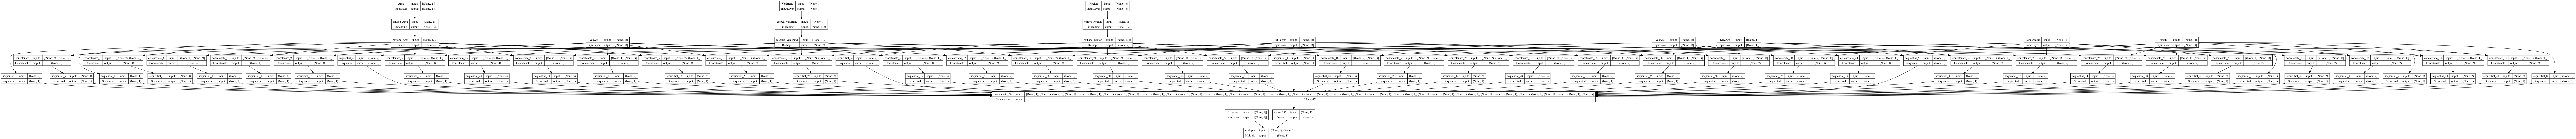

In [352]:
#-------------------------- plot model --------------------------
plot_model(model_NAM, show_layer_names = True, show_shapes = True)

In [353]:
#-------------------------- evaluate on testing data --------------------------

# split testing data into different sets
X_test_split = []
for i in range(len(feature_names)):
    X_test_split.append(test_NAM[:, i])

# evaluation
nam_poisson_loss, nam_mse, _ = model_NAM.evaluate(X_test_split, y_test)
print(f"NAM test set metrics ~ Poisson loss: {nam_poisson_loss:.4f}, MSE: {nam_mse:.4f}")

5297/5297 [==============================] - 8s 1ms/step - loss: 0.2018 - mean_squared_error: 0.0554 - poisson: 0.2018
NAM test set metrics ~ Poisson loss: 0.2018, MSE: 0.0554


In [354]:
############################ 3. GLM ############################

#-------------------------- preprocessing --------------------------

# define transformer
ct = make_column_transformer(
    ("passthrough", ["Exposure"]),
    (OrdinalEncoder(), ["Area", "VehGas"]),
    (OneHotEncoder(), ["VehBrand", "Region"]),
    remainder = StandardScaler(),
    verbose_feature_names_out = False
)

# fit & transform
train = ct.fit_transform(X_train).toarray()
test = ct.transform(X_test).toarray()
feature_names = ct.get_feature_names_out()  # get the columns' names


'''we want to use dummy encoding for VehBrand and Region so 2 columns need
to be removed from both training and test data. These 2 columns are the reference
levels for VehBrand and Region. Choose B12 for VehBrand and Centre for Region.'''

# separate the offset term (or exposure)
offset_train = train[:, 0]
offset_test = test[:, 0]

# index for reference level in feature_names
ref_index = [np.where(feature_names == "VehBrand_B12")[0][0],
             np.where(feature_names == "Region_Centre")[0][0]]
ref_index.append(0) # Exposure

# remove reference levels
train_dummy = np.delete(train, ref_index, axis = 1)
test_dummy = np.delete(test, ref_index, axis = 1)
feature_dummy = [feature for i, feature in enumerate(feature_names) if i not in ref_index]

# add a constant to the model (intercept)
train_dummy = sm.add_constant(train_dummy)
test_dummy = sm.add_constant(test_dummy)

In [355]:
train_dummy

array([[ 1.        ,  4.        ,  1.        , ..., -0.60040141,
        -0.6243503 ,  0.23233027],
       [ 1.        ,  4.        ,  1.        , ...,  0.53150309,
        -0.6243503 ,  0.74897587],
       [ 1.        ,  2.        ,  0.        , ...,  1.23894341,
         0.26966047, -0.38501957],
       ...,
       [ 1.        ,  1.        ,  0.        , ...,  0.1070389 ,
        -0.6243503 , -0.43827419],
       [ 1.        ,  3.        ,  1.        , ..., -1.0248656 ,
        -0.6243503 , -0.08290683],
       [ 1.        ,  1.        ,  0.        , ...,  2.01712775,
        -0.6243503 , -0.43423593]])

In [356]:
#-------------------------- fit a GLM model --------------------------
model_GLM = sm.GLM(y_train, train_dummy, family = sm.families.Poisson(), offset = offset_train)
results = model_GLM.fit()
# results.summary()

In [357]:
#-------------------------- evaluation --------------------------
GLM_pred = results.predict(test_dummy, offset = offset_test)
GLM_mse = mse(y_test, GLM_pred)
print(GLM_mse)

0.055791255531902284


In [358]:
# Calculate the Poisson loss for the GLM model which Keras uses
glm_poisson_loss = keras.losses.Poisson()(y_test, GLM_pred).numpy()
glm_poisson_loss

0.20293348834023647

In [359]:
############################ 4. NEURAL NETWORKS ############################

#-------------------------- preprocessing --------------------------
ct_NN = make_column_transformer(
    ("passthrough", ["Exposure"]),
    (OrdinalEncoder(), ["Area", "VehGas", "VehBrand", "Region"]),
    remainder = StandardScaler(),
    verbose_feature_names_out = False)


# transform the data
train_NN = ct_NN.fit_transform(X_train)
test_NN = ct_NN.transform(X_test)
feature_names_NN = ct_NN.get_feature_names_out()  # get the columns' names


# separate exposure column
exposure_index = np.where(feature_names_NN == "Exposure")[0][0] # index of the Exposure column
train_exposure = train_NN[:,exposure_index]
test_exposure = test_NN[:,exposure_index]


# separate multi-level categorical columns
categorical_var = ["Area", "VehBrand", "Region"]
train_cat = []
test_cat = []
cat_index = []
for i in range(len(categorical_var)):
    index = np.where(feature_names_NN == categorical_var[i])[0][0]
    train_cat.append(train_NN[:,index])
    test_cat.append(test_NN[:,index])
    cat_index.append(index)

                    
# drop exposure and nominal categorical columns
train_others = np.delete(train_NN, [exposure_index] + cat_index, axis = 1)
test_others = np.delete(test_NN, [exposure_index] + cat_index, axis = 1)

In [360]:
#-------------------------- define model architecture --------------------------

'''Define model architecture'''
def build_NN(hp):
    
    exposure = Input(shape=(1,), name = "exposure") # exposure
    cat_inputs = [] # input layers for categorical features
    embedding_layers = [] # embedding layers
    embedding_dim = hp.Int('embedding_dim', 2, 4, step = 1)
    for cat_column in categorical_var:

        # input layers
        cat_input = Input(shape = (1,), name = f"input_{cat_column}")  # assuming categorical vars are single integers
        cat_inputs.append(cat_input)

        # embedding layers
        embed_layer = Embedding(input_dim = claimfreq[cat_column].nunique(), 
                                output_dim = embedding_dim, 
                                name = f"embed_{cat_column}")(cat_input)
        embed_layer_reshape = Reshape(target_shape = (embedding_dim,), name = f"reshape_{cat_column}")(embed_layer)

        embedding_layers.append(embed_layer_reshape)
        
    other_inputs = Input(shape = train_others.shape[1:])
    inputs = Concatenate(name = "combined_input")(embedding_layers + [other_inputs])

    # dense layers
    x = inputs
    activation = hp.Choice('activation', ['relu', 'leaky_relu', 'swish', 'gelu'])
    dropout_rate = hp.Float(f'dropout', min_value = 0.2, max_value = 0.5, step = 0.1)
    for i in range(hp.Int('num_dense_layers', 2, 5, step = 2)):
        num_units = hp.Int(f'num_units_{i}', 32, 128, step = 16)
        x = Dense(units = num_units, activation = activation)(x)
        x = Dropout(dropout_rate)(x)
    lambda_ = Dense(1, "exponential")(x)

    # final output
    out = Multiply()([lambda_, exposure])
    model = Model([exposure] + cat_inputs + [other_inputs], out)

    # optimizer
    lr = hp.Float('learning_rate', min_value = 1e-4, max_value = 1e-2, sampling = 'log')
    optimizer = Nadam(learning_rate = lr)
    
    # build model
    model.compile(optimizer = optimizer,
              loss = "poisson", 
              metrics = ['mean_squared_error', 'poisson'])
    
    return model

In [361]:
#-------------------------- tune and fit fit a deep NN --------------------------
# tuner
tuner = kt.RandomSearch(
    build_NN,
    objective = 'val_loss',
    max_trials = 10,  # Increased trials due to additional hyperparameters
    directory = "hyperparameter_tuning_NN",
    seed = 2025 # for reproducibility
)

# regularization
es = EarlyStopping(patience = 10, restore_best_weights = True, verbose = 0)

# search for the best model
tuner.search([train_exposure, train_cat, train_others], y_train,
            epochs = 500,  
            batch_size = 1000, 
            validation_split = 0.2,
            callbacks = [es])

# get the best model
model_NN = tuner.get_best_models()[0]
tuner.results_summary(1)

Trial 10 Complete [00h 00m 54s]
val_loss: 0.20241756737232208

Best val_loss So Far: 0.2022201120853424
Total elapsed time: 00h 15m 17s
Results summary
Results in hyperparameter_tuning_NN/untitled_project
Showing 1 best trials
Objective(name="val_loss", direction="min")

Trial 00 summary
Hyperparameters:
embedding_dim: 3
activation: relu
dropout: 0.2
num_dense_layers: 2
num_units_0: 112
num_units_1: 64
learning_rate: 0.0021291840426046296
Score: 0.2022201120853424


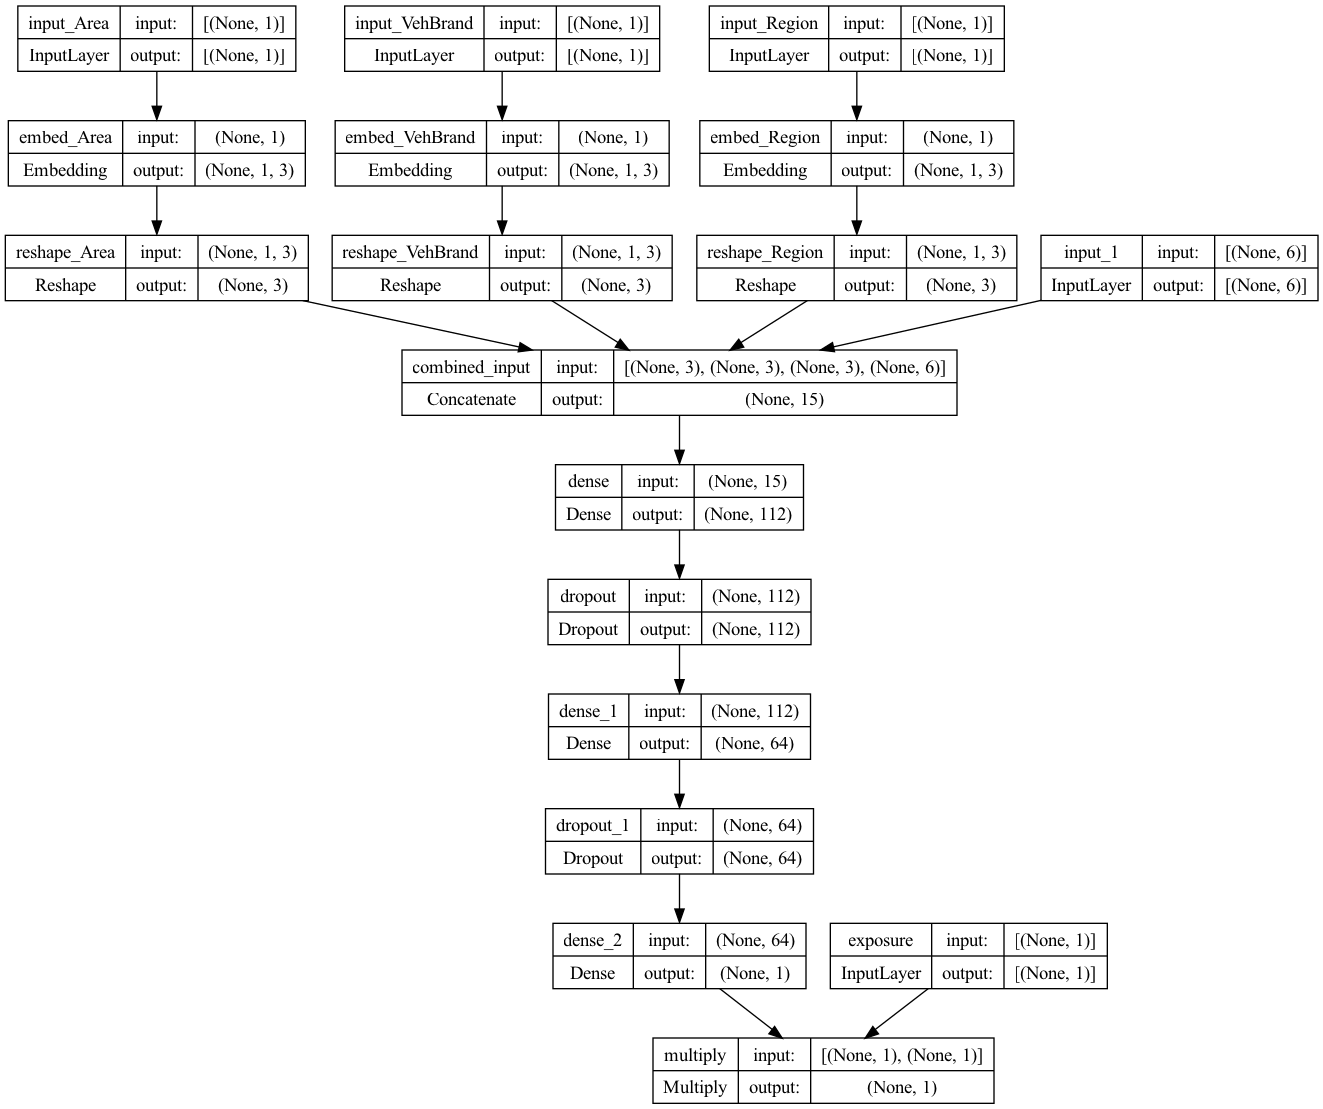

In [362]:
#-------------------------- plot model --------------------------
plot_model(model_NN, show_layer_names = True, show_shapes = True)

In [363]:
#-------------------------- evaluate on test set --------------------------
nn_poisson_loss, nn_mse, _ = model_NN.evaluate([test_exposure, test_cat, test_others], y_test)
print(f"NN test set metrics ~ Poisson loss: {nn_poisson_loss:.4f}, MSE: {nn_mse:.4f}")

5297/5297 [==============================] - 2s 440us/step - loss: 0.2019 - mean_squared_error: 0.0553 - poisson: 0.2019
NN test set metrics ~ Poisson loss: 0.2019, MSE: 0.0553


In [364]:
# Print all the results
print(f"GLM test set metrics \t Poisson loss: {glm_poisson_loss:.4f} \t MSE: {GLM_mse:.4f}")
print(f"NAM test set metrics \t Poisson loss: {nam_poisson_loss:.4f} \t MSE: {nam_mse:.4f}")
print(f"NN test set metrics \t Poisson loss: {nn_poisson_loss:.4f} \t MSE: {nn_mse:.4f}")

GLM test set metrics 	 Poisson loss: 0.2029 	 MSE: 0.0558
NAM test set metrics 	 Poisson loss: 0.2018 	 MSE: 0.0554
NN test set metrics 	 Poisson loss: 0.2019 	 MSE: 0.0553
